# DRACO - Milestone 2: Dataset exploration

This document is structured as follow:

1. Characters Data - Extraction and Processing
2. Movie Data - Extraction and Processing
3. Actors Ethinicites - Exploration

---

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
DATA_FOLDER = './Data/'

CHARACTER_PATH = DATA_FOLDER + 'MovieSummaries/character.metadata.tsv'
MOVIE_PATH = DATA_FOLDER + 'MovieSummaries/movie.metadata.tsv'
ETHNICITY_PATH = DATA_FOLDER + 'ethnicities_data.tsv'

## Characters Data - Extraction and Processing

First, we will load the character dataset and the ethnicity dataset. This is done to subsequently merge the two dataframes, connecting the characters with the ethnicity of the actors.

In [4]:
characters_original = pd.read_csv(CHARACTER_PATH, sep='\t', header=None, 
    names = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie release date", "Character name", "Birth", 
    "Gender", "Height", "Ethnicity ID", "Name", "Age at movie release",
    "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters = characters_original.copy()
characters.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [5]:
ethnicities_data_original = pd.read_csv(ETHNICITY_PATH, sep='\t',  
                               header=0, names=["Ethnicity ID", "Ethnicity"])
ethnicities_data = ethnicities_data_original.copy()
ethnicities_data.head()

,Ethnicity ID,Ethnicity
0,/m/044038p,NaN
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/041rx,Jewish people
4,/m/033tf_,Irish Americans


After loading both datasets, we'll perform an inner join on the column `Ethnicity ID` to retain only the pertinent information.

In [6]:
characters = characters_original.copy().merge(ethnicities_data.dropna(), how='inner', on='Ethnicity ID')
characters.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Ethnicity
0,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
1,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans
2,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,African Americans
3,156558,/m/014k4y,2001-06-27,Yvette,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,/m/0jtx5t,/m/03jnxj_,/m/0blbxk,African Americans
4,156558,/m/014k4y,2001-06-27,Jody,1978-12-30,M,1.797,/m/0x67,Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,African Americans


## Movie Data - Extraction and Processing

Next, we load the movie dataset. This is essential as we plan to merge the character dataframe with the movie dataframe, creating a comprehensive dataframe that encompasses all character-related information.

In [7]:
movies_original = pd.read_csv(MOVIE_PATH, sep='\t', header=None, 
    names = ["Wikipedia Movie ID", "Freebase Movie ID", "Movie name","Movie release date", "Box office revenue","Movie runtime","Movie language","Movie countries","Movie genres" ])
movies = movies_original.copy()
movies.head()

,Wikipedia Movie ID,Freebase Movie ID,Movie name,Movie release date,Box office revenue,Movie runtime,Movie language,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


We can observe that the three columns `Movie language`, `Movie language`, `Movie genres` contain dictionaries. In our case, it would be much more convenient to have lists instead. Let's process it accordingly

In [8]:
movies["Movie countries"] = movies["Movie countries"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies["Movie language"] = movies["Movie language"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies["Movie genres"] = movies["Movie genres"].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

We should also add a category for the year of release in addition of the date of release

In [9]:
#Errors = 'coerce' will force the values that are outside the bound to be NaT
movies["Movie release year"] = pd.to_datetime(movies["Movie release date"],format='mixed',errors = 'coerce').dt.year
#Remove the NaN and NaT values
movies = movies[movies["Movie release year"].notna()]
#Express all years of realese as int.
movies["Movie release year"] = movies["Movie release year"].astype("int")


Now, let's merge the movie dataframe with the character dataframe to create a single dataframe that encompasses all the information about a character along with details about the films they are involved in.

In [10]:
characters_movies = characters.merge(movies, how='inner', on=['Wikipedia Movie ID',"Freebase Movie ID","Movie release date"])
characters_movies.head()


,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Birth,Gender,Height,Ethnicity ID,Name,Age at movie release,...,Freebase character ID,Freebase actor ID,Ethnicity,Movie name,Box office revenue,Movie runtime,Movie language,Movie countries,Movie genres,Movie release year
0,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/0bgchn_,/m/01vw26l,African Americans,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
1,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,...,/m/0bgchnd,/m/0418ft,African Americans,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
2,975900,/m/03vyhn,2001-08-24,Tres,1959-03-09,M,NaN,/m/064b9n,Rodney A. Grant,42.0,...,/m/0bgchrw,/m/03ydsb,Omaha people,Ghosts of Mars,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001
3,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,...,NaN,/m/01lntp,African Americans,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000
4,156558,/m/014k4y,2001-06-27,Yvette,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,...,/m/03jnxj_,/m/0blbxk,African Americans,Baby Boy,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",2001


## Actors Ethinicites - Exploration

Let's visualized the proportion of ethinicties among the characters.

<Axes: xlabel='Ethnicity'>

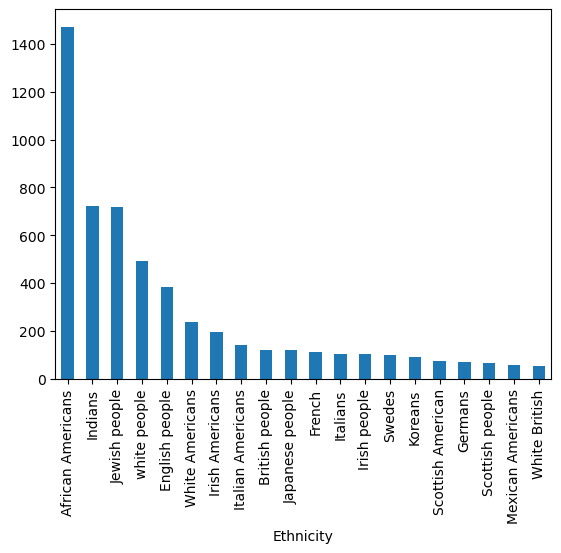

In [65]:
actors_no_duplicates=characters.copy().drop_duplicates(subset='Freebase actor ID')
grouped_ethnicity=actors_no_duplicates.groupby('Ethnicity').count()
grouped_ethnicity['Freebase actor ID'].sort_values(ascending=False)[0:20].plot(kind='bar')

Text(0, 0.5, 'Number of actors')

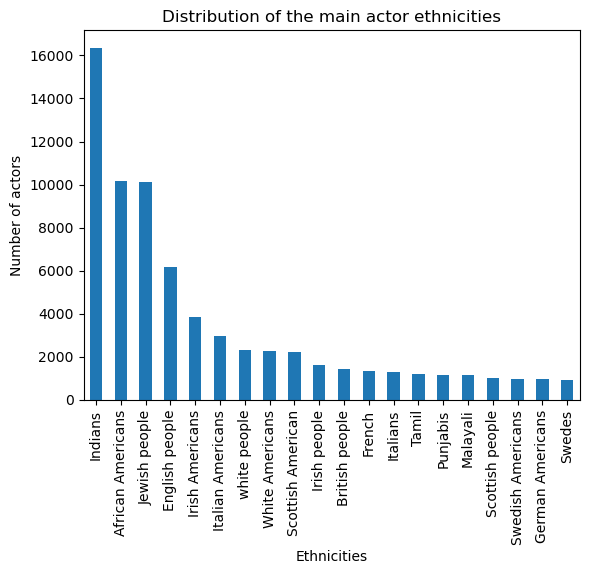

In [54]:
grouped_ethinity = characters.groupby(['Ethnicity']).count()
#grouped_ethinity = grouped_ethinity.div(grouped_ethinity.sum(axis=1), axis=0)
main_ethnicities = grouped_ethinity['Freebase actor ID'].sort_values(ascending=False)[0:20]
main_ethnicities.plot(kind='bar')
plt.title("Distribution of the main actor ethnicities")
plt.xlabel("Ethnicities")
plt.ylabel("Number of actors")

We've noticed that many characters are portrayed by Indian actors. For our project, our primary focus is on Hollywood characters. Let's see if this choice is representavie of the movie industry.

In [12]:
characters_movies_main_country = characters_movies[characters_movies["Movie countries"] != "NaN"].copy()
characters_movies_main_country["Movie countries"] = characters_movies_main_country["Movie countries"].apply(lambda x: x[0])

In [13]:
nb_actors_per_industries = characters_movies_main_country.groupby(['Movie countries']).count()['Freebase actor ID'].sort_values(ascending=False)
nb_actors_per_industries.head(10)

Movie countries
United States of America    56266
India                       23708
United Kingdom               4549
France                       3443
Italy                         924
Canada                        918
Hong Kong                     717
Japan                         715
Australia                     462
Spain                         460
Name: Freebase actor ID, dtype: int64

To have a better view of the main industries let's consider only the industires with more than 1000 actors.

In [14]:
nb_actors_per_industries['Other'] = nb_actors_per_industries[nb_actors_per_industries < 1000].sum()
nb_actors_per_industries = nb_actors_per_industries[nb_actors_per_industries > 1000].sort_values(ascending=False)

<Axes: title={'center': 'Proportion of actors per industries'}>

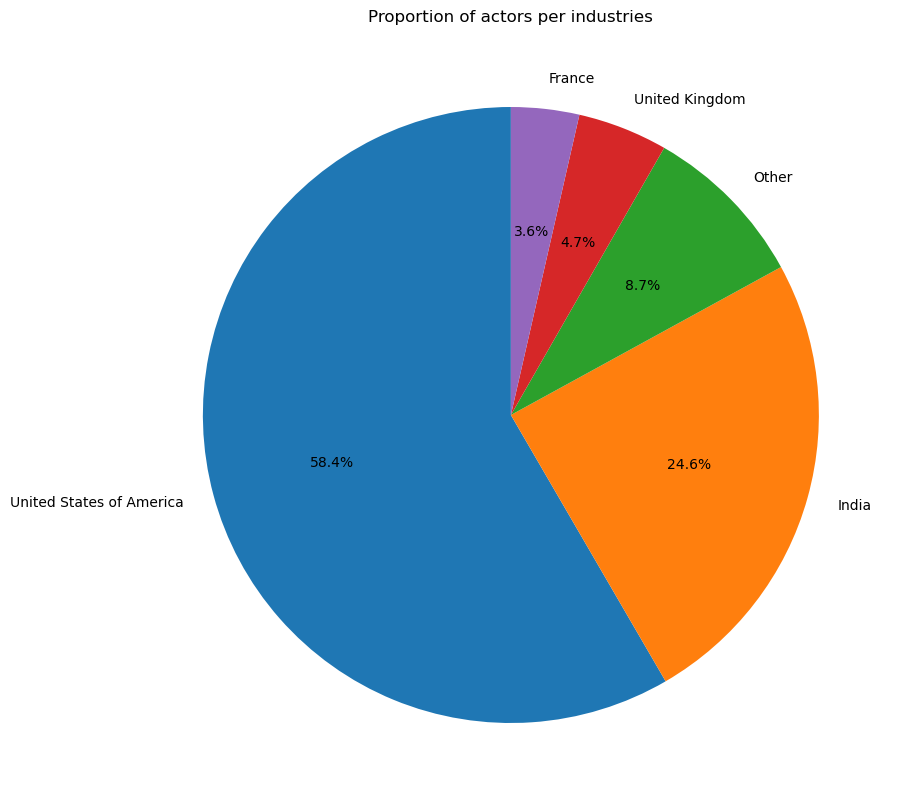

In [15]:
nb_actors_per_industries.plot.pie(figsize=(10, 10), autopct='%1.1f%%', startangle=90, title='Proportion of actors per industries', label='')




Let's narrow down our selection to include only Hollywood or American characters, meaning those characters that appear in American movies

In [16]:
characters_holywood = characters_movies.copy()[characters_movies["Movie countries"].apply(lambda x: 'United States of America' in x)]

Plus we should also remove the actor that have only played in animation, as they're probably voice actors

In [17]:
# First let's see all the unique genres, to discard the animation ones:
unique_genres = set()
characters_holywood['Movie genres'].apply(lambda x: unique_genres.update(x))
print(unique_genres)

{'Operetta', 'Coming of age', 'Surrealism', 'Wuxia', 'Softcore Porn', 'Splatter film', 'Bollywood', 'B-movie', 'Comedy of Errors', 'Female buddy film', 'Outlaw', 'Gay Interest', 'Glamorized Spy Film', 'Beach Film', 'Short Film', 'Alien invasion', 'Religious Film', 'Biopic [feature]', 'Cyberpunk', 'Musical comedy', 'Erotic thriller', 'Tragedy', 'Psycho-biddy', 'Romance Film', 'Gay', 'Law & Crime', 'Gothic Film', 'Chick flick', 'Foreign legion', 'Inventions & Innovations', 'Computers', 'Sci Fi Pictures original films', 'Humour', 'Teen', 'Family Film', 'Experimental film', 'Interpersonal Relationships', 'War film', 'Film adaptation', 'Crime Drama', 'Live action', 'Avant-garde', 'History', 'Auto racing', 'LGBT', 'Illnesses & Disabilities', 'Bloopers & Candid Camera', 'Suspense', 'Archives and records', 'Comedy', 'Outlaw biker film', 'Romantic fantasy', 'Beach Party film', 'Historical Epic', 'Punk rock', 'Stoner film', "Children's Entertainment", 'Biography', 'Heist', 'Chase Movie', 'News',

In [18]:
values_to_find = ['Anime', 'Animation', 'Computer Animation', 'Clay animation', 'Animated cartoon','Stop motion']
characters_holywood = characters_holywood[characters_holywood['Movie genres'].apply(lambda x: not(any(value in x for value in values_to_find)))]


By grouping the data by ethnicities, let's analyse what are the main ethnicties of Hollywoodian actors

In [19]:
H_grouped_ethnicity = characters_holywood.groupby(['Ethnicity']).count()
#Let's take the 10 main actor ethinicities
main_ethinicities = H_grouped_ethnicity['Freebase actor ID'].sort_values(ascending=False)[0:10].index
main_characters_holywood = characters_holywood[characters_holywood['Ethnicity'].isin(main_ethinicities)]
main_ethinicities

Index(['African Americans', 'Jewish people', 'Irish Americans',
       'English people', 'Italian Americans', 'Scottish American',
       'White Americans', 'white people', 'Irish people', 'Swedish Americans'],
      dtype='object', name='Ethnicity')

Now let's visualize the distribution of holywoodian actors

Text(0, 0.5, 'Number of actors')

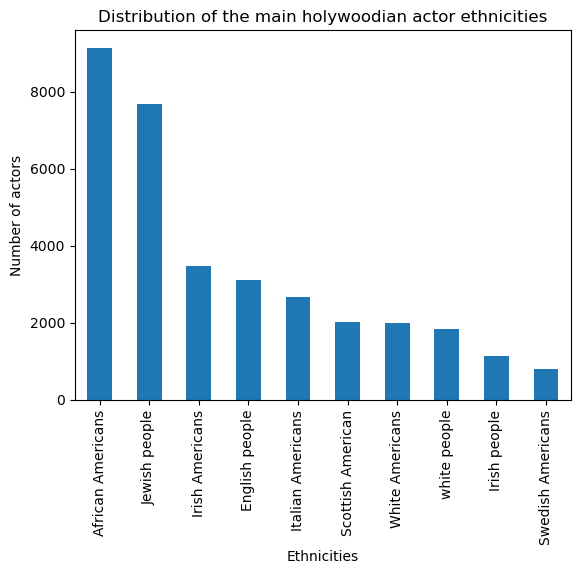

In [20]:
main_holywoodian_ethnicities =  H_grouped_ethnicity.loc[main_ethinicities]['Freebase actor ID']
main_holywoodian_ethnicities.plot(kind='bar')
plt.title("Distribution of the main holywoodian actor ethnicities")
plt.xlabel("Ethnicities")
plt.ylabel("Number of actors")

Analysze the sex distribution by ethnicities 

In [21]:
H_ethinity_M = main_characters_holywood[main_characters_holywood['Gender'] == 'M'].groupby(['Ethnicity'])['Freebase actor ID'].count().sort_values()
H_ethinity_M_reversed = H_ethinity_M*(-1)
H_ethinity_F = main_characters_holywood[main_characters_holywood['Gender'] == 'F'].groupby(['Ethnicity'])['Freebase actor ID'].count().sort_values()


Text(0.5, 1.0, 'Sex distribtion depending on the ethincity over all time')

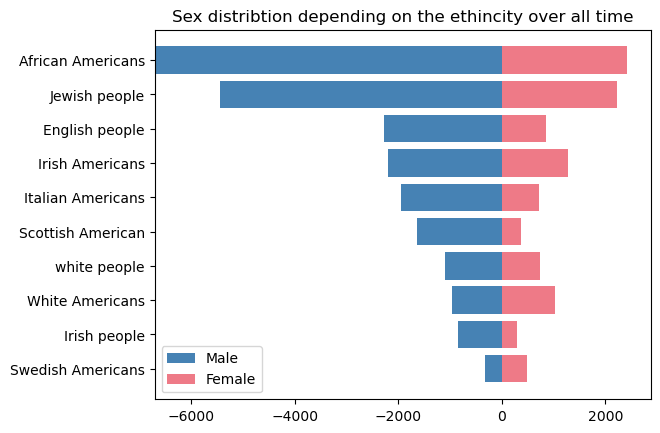

In [22]:
plt.barh(y=H_ethinity_M.index, width=H_ethinity_M.values, left=H_ethinity_M_reversed.values, color="#4682b4", label="Male")
plt.barh(y=H_ethinity_F.index, width=H_ethinity_F.values, 
         color="#ee7a87", label="Female")
plt.legend()
plt.title("Sex distribtion depending on the ethincity over all time")

Text(0, 0.5, 'Proportion')

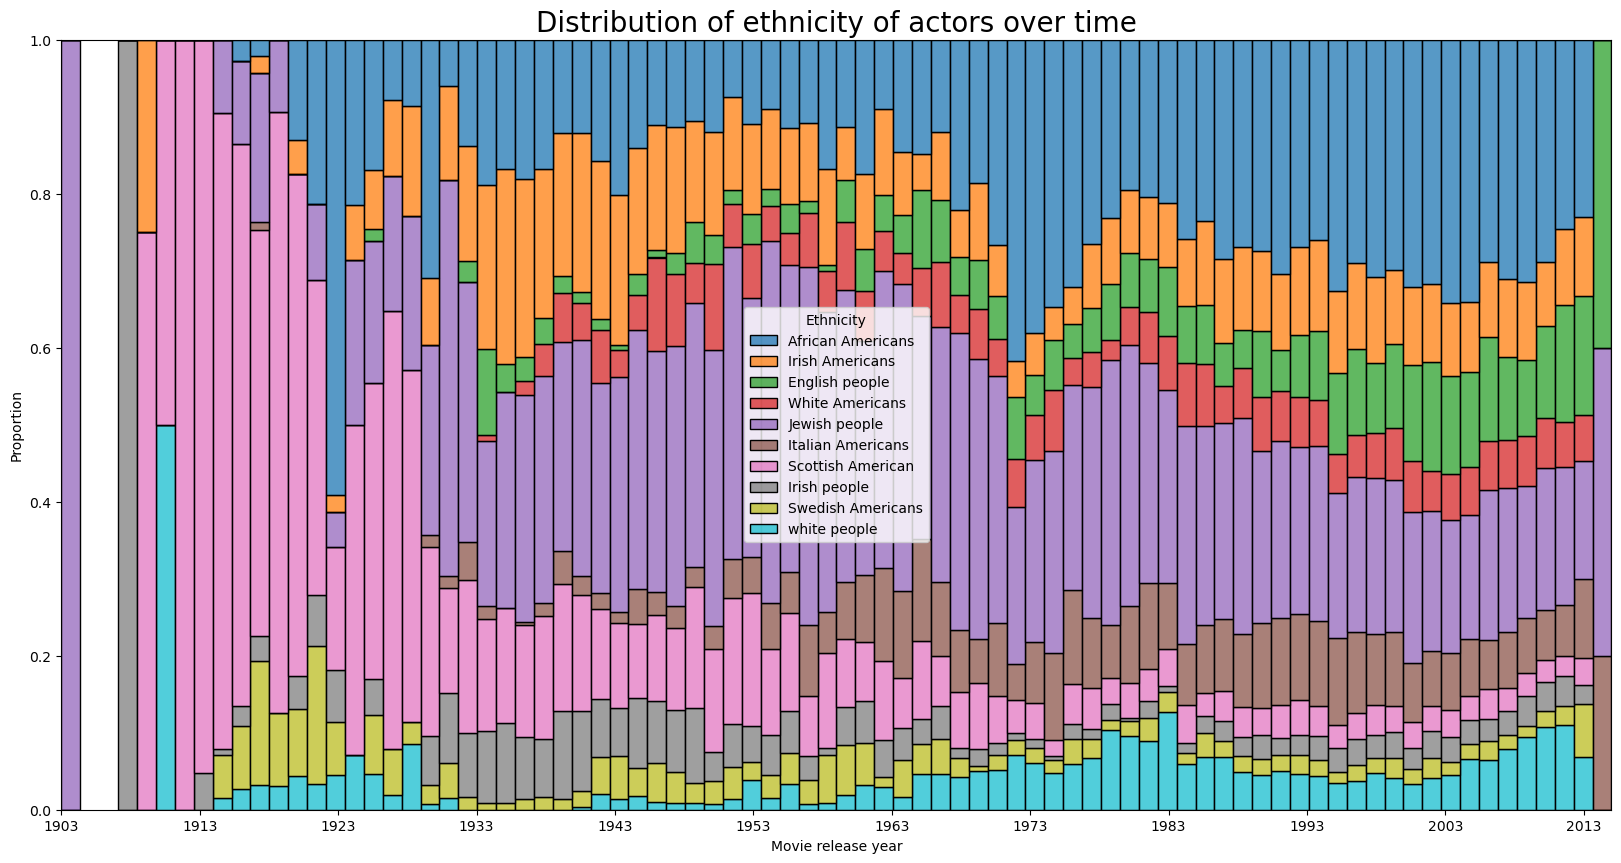

In [23]:
plt.figure(figsize=(20,10))
sns.histplot(data=main_characters_holywood,x='Movie release year',hue='Ethnicity',multiple='fill',stat='probability')
plt.title("Distribution of ethnicity of actors over time",fontsize=20)
plt.xticks(np.arange(main_characters_holywood['Movie release year'].min(),main_characters_holywood['Movie release year'].max(),10))
plt.ylabel('Proportion')


(2020.0, 1900.0)

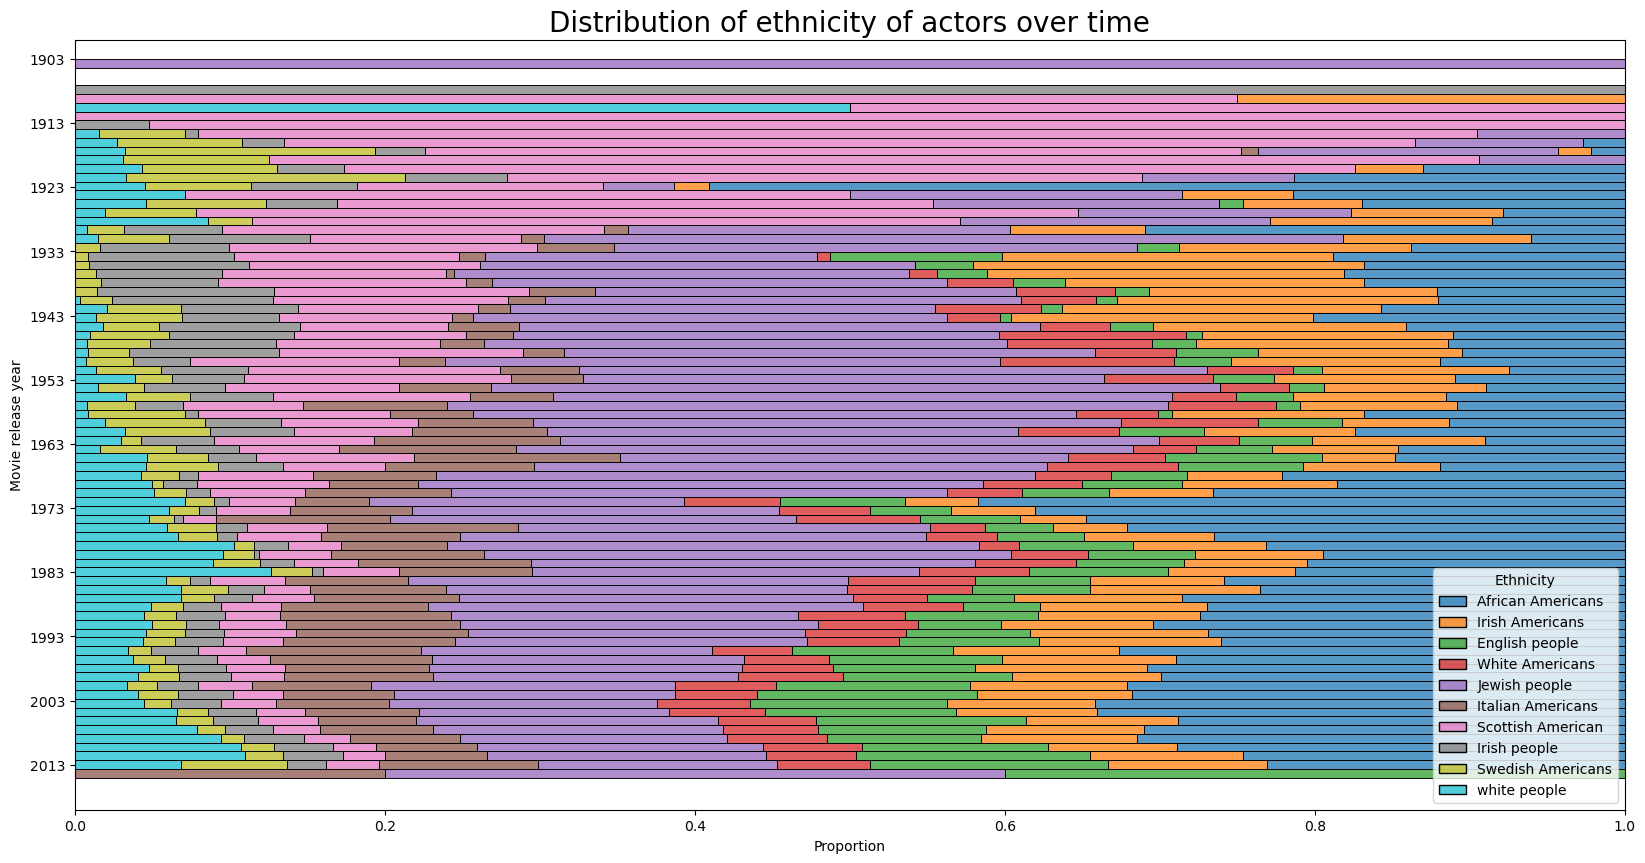

In [24]:
# Same plot but with diffrent orientationm for bettwer visibility
plt.figure(figsize=(20,10))
sns.histplot(data=main_characters_holywood, y='Movie release year', hue='Ethnicity', multiple='fill', stat='probability')
plt.title("Distribution of ethnicity of actors over time",fontsize=20)
plt.yticks(np.arange(main_characters_holywood['Movie release year'].min(), main_characters_holywood['Movie release year'].max(), 10))
plt.xlabel('Proportion')
plt.ylim(2020, 1900)

Now, create a pyramid plot to show the difference between ethnicities over the years.

In [25]:
# Let's groupby Ethincity and Year and separate the genders.
H_ethinity_M_year = main_characters_holywood[main_characters_holywood['Gender'] == 'M'].groupby(['Ethnicity', 'Movie release year'])['Freebase actor ID'].count().sort_values()

H_ethinity_F_year = main_characters_holywood[main_characters_holywood['Gender'] == 'F'].groupby(['Ethnicity', 'Movie release year'])['Freebase actor ID'].count().sort_values()

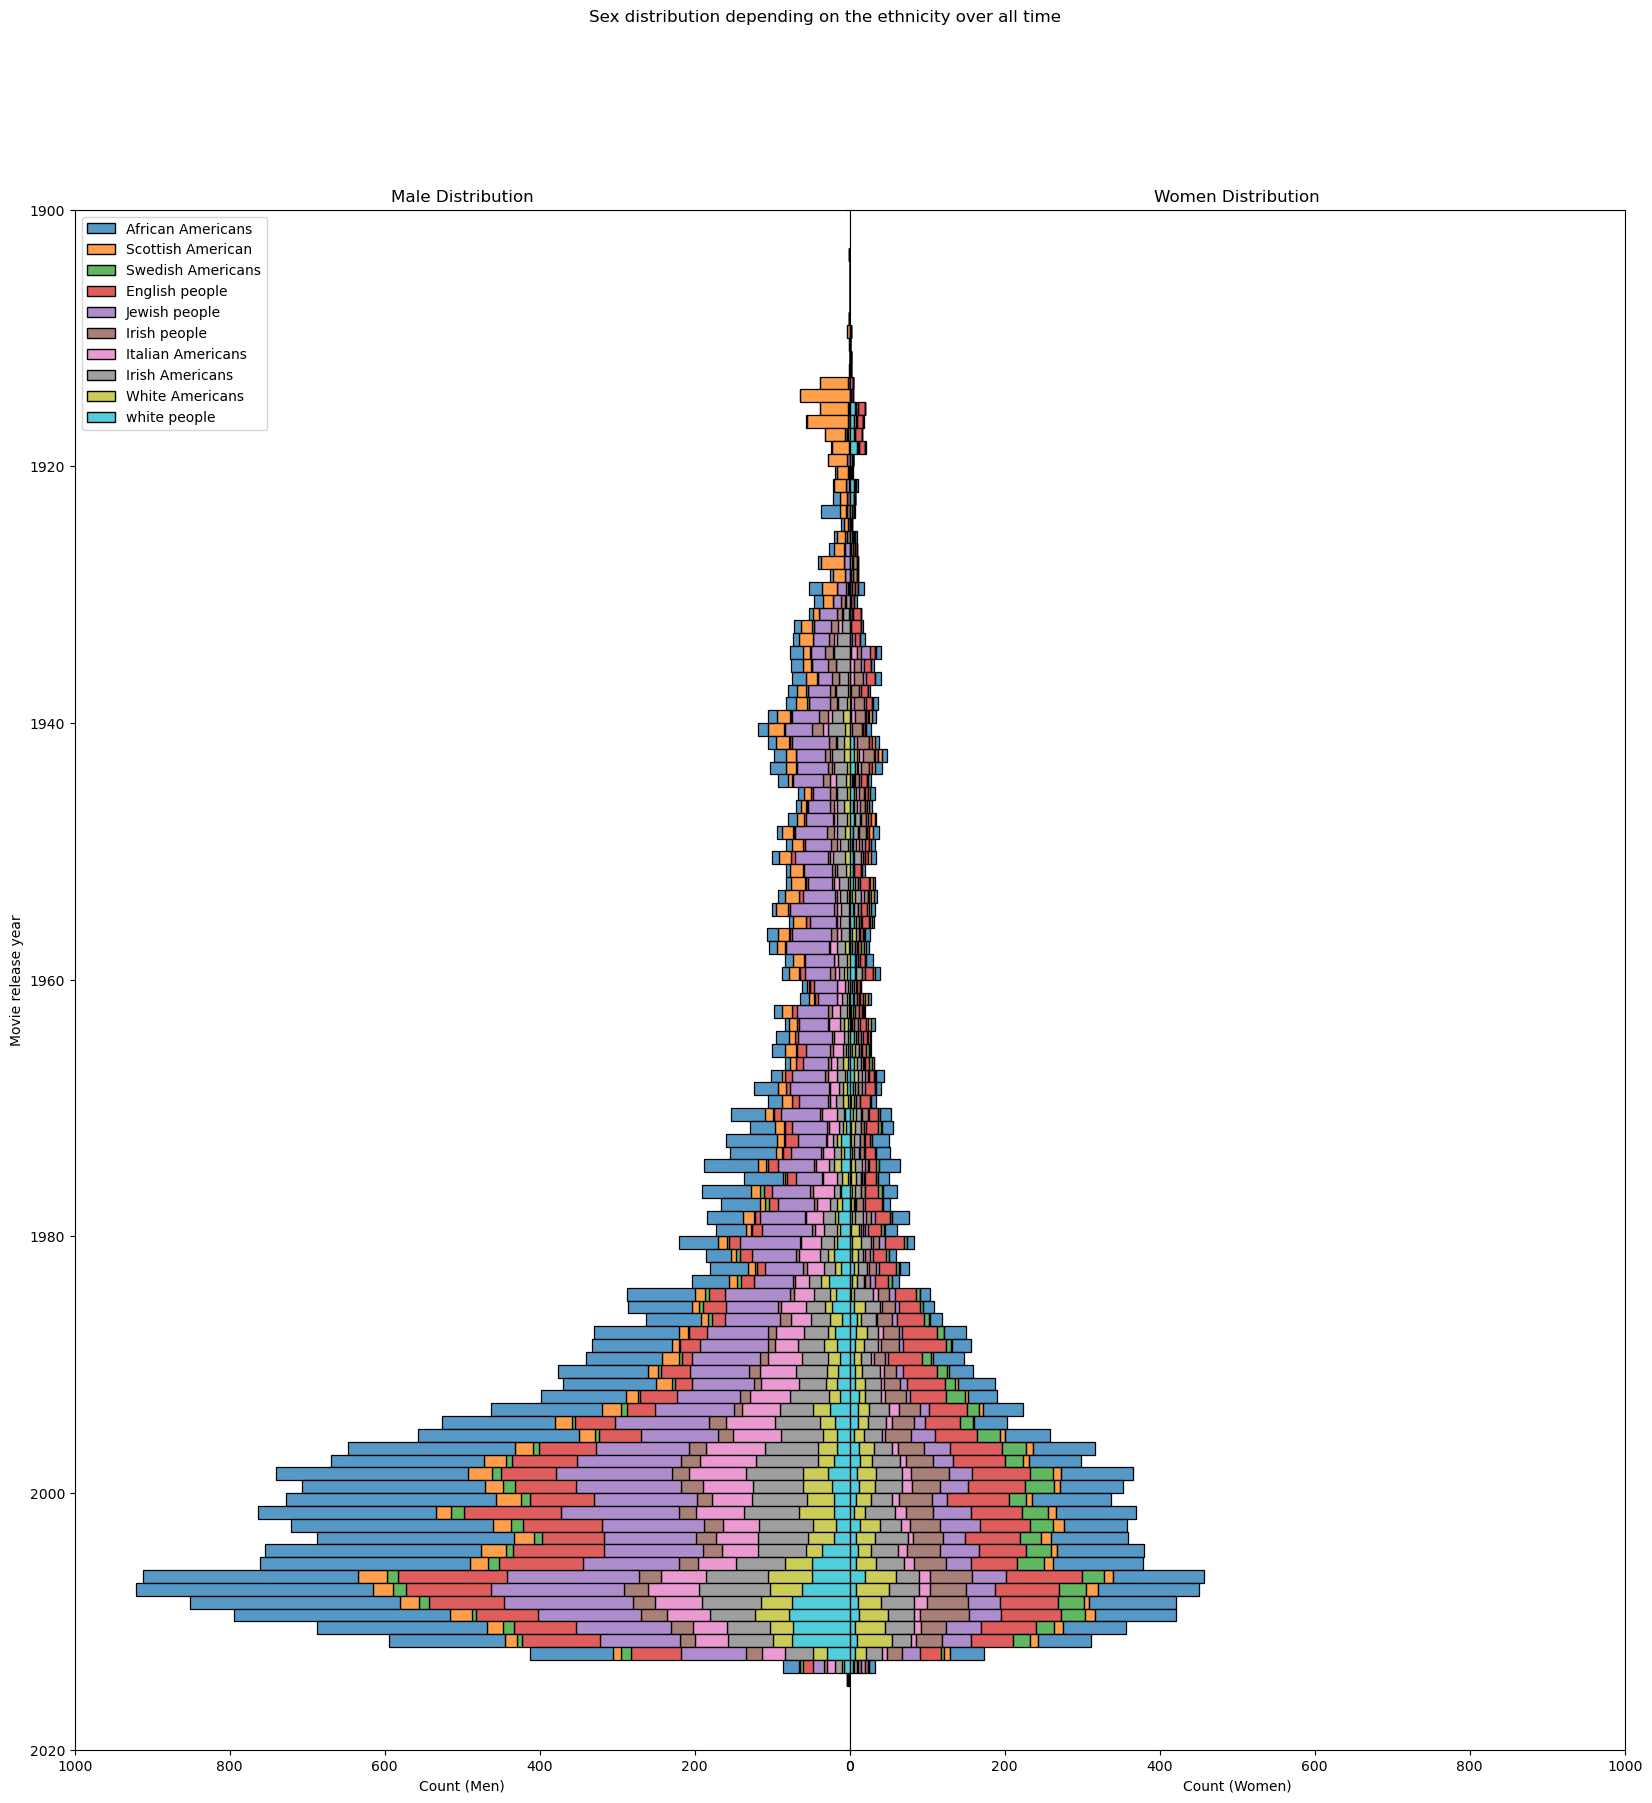

In [26]:
ethnicities_M, years_M = zip(*H_ethinity_M_year.index)
ethnicities_F, years_F = zip(*H_ethinity_F_year.index)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 20))
plt.subplots_adjust(wspace=0)

# Plot for men
sns.histplot(ax=ax[0], y=list(years_M), weights=np.abs(H_ethinity_M_year.values), hue=list(ethnicities_M), multiple='stack', stat='count', binwidth=1)

ax[0].set_xlabel("Count (Men)")
ax[0].invert_xaxis()# Flip the x-axis
ax[0].set_ylabel("Movie release year")
ax[0].set_ylim(2020, 1900)  # Flip the y-axis
ax[0].set_xlim(1000, 0)
ax[0].set_title('Male Distribution')

# Plot for women
sns.histplot(ax=ax[1], y=list(years_F), weights=np.abs(H_ethinity_F_year.values), hue=list(ethnicities_F), multiple='stack', stat='count', binwidth=1, legend= False)
  
ax[1].set_xlabel("Count (Women)")
ax[1].set_ylim(2020, 1900)  # Flip the y-axis
ax[1].set_xlim(0, 1000)
ax[1].set_title('Women Distribution')

plt.suptitle("Sex distribution depending on the ethnicity over all time")
plt.show()

                   Not named characters
Ethnicity                              
African Americans             50.579996
English people                24.759461
Irish Americans               29.625360
Irish people                  26.269702
Italian Americans             33.896396
Jewish people                 41.431925
Scottish American             47.014925
Swedish Americans             27.798278
White Americans               33.802817
white people                  35.632808


Text(0, 0.5, 'Percentage of not named characters')

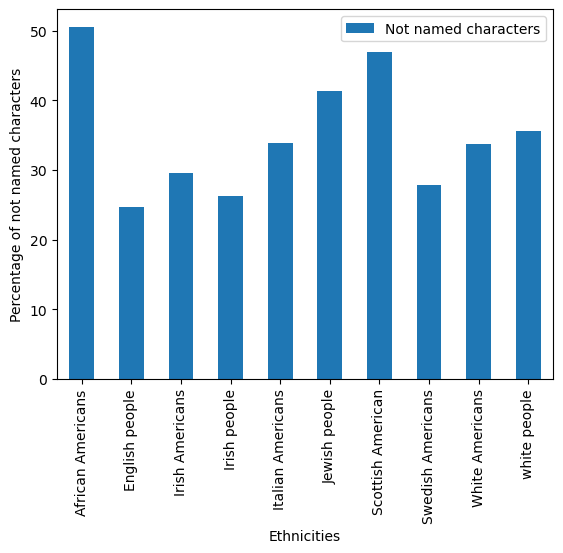

In [27]:
no_name_characters=main_characters_holywood.groupby('Ethnicity').apply(lambda x: pd.Series({
        'Not named characters': x['Character name'].isna().sum()*100/len(x['Character name'])
    }))
print(no_name_characters)
no_name_characters.plot(kind='bar')
plt.xlabel('Ethnicities')
plt.ylabel('Percentage of not named characters')

In [31]:
this=main_characters_holywood.groupby('Movie name').apply(lambda x: pd.DataFrame({
        'Number of ethnicities': x['Ethnicity'].nunique(),
        'Revenue': x['Box office revenue'].drop_duplicates()
    }))
this=this.dropna()

<Axes: xlabel='Number of ethnicities', ylabel='Revenue'>

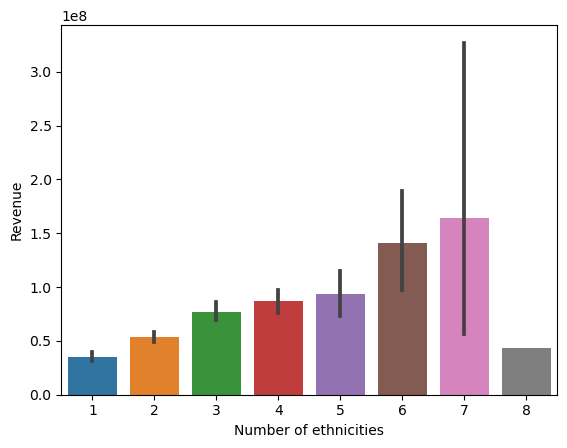

In [29]:
sns.barplot(data=this, x='Number of ethnicities', y='Revenue')